In [1]:
%matplotlib inline

# Introduction

The following is a decision tree model trained to differentiate between 5400 blue +'s and 5400 red x's.

# Import Dependencies

We begin by importing the necessary libraries.

In [2]:
# Utility
import random

# Data analysis
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
from tqdm import tqdm

# Generate Data

Then, we generate the training/test data based on the following distributions:
*   5000 blue +'s following a Gaussian distribution, centered at `(10, 10)`
*   400 blue +'s following a uniform distribution within the range `[0, 20)`
*   5400 red x's following a uniform distribution within the range `[0, 20)`

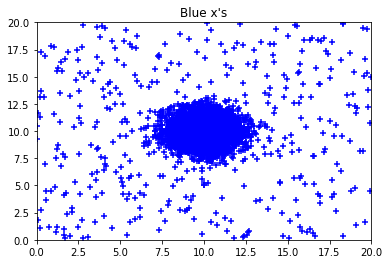

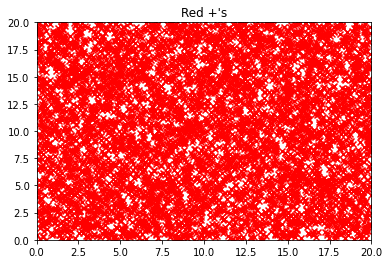

In [3]:
# Generate blue +'s
x1 = [(np.random.normal(loc=10), np.random.normal(loc=10)) for _ in range(5000)]
x1.extend([(np.random.uniform(high=20), np.random.uniform(high=20)) for _ in range(400)])

# Generate red x's
x2 = [(np.random.uniform(high=20), np.random.uniform(high=20)) for _ in range(5400)]

# Visualize data
plt.scatter([x[0] for x in x1], [y[1] for y in x1], c='b', marker='+')
plt.title('Blue x\'s')
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.show()

plt.scatter([x[0] for x in x2], [y[1] for y in x2], c='r', marker='x')
plt.title('Red +\'s')
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.show()

Once our data has been generated, we create a DataFrame to store our coordinates and labels (0: blue +'s, 1: red x's).

In [4]:
# Combine the blue +'s and red x's
x1.extend(x2)
X = x1

# Generate labels 
y = [0 for _ in range(5400)]
y.extend([1 for _ in range(5400)])

# Create DataFrame to store data
data_df = pd.DataFrame({'Coordinates': X, 'Labels': y})

In [5]:
# Display the (unshuffled) DataFrame
data_df

,Coordinates,Labels
0,"(9.26290942030753, 10.273226959263942)",0
1,"(10.1308062287478, 8.70656215972824)",0
2,"(8.929382175590689, 10.216441584337048)",0
3,"(10.965725901536928, 10.280736580332796)",0
4,"(10.819100895243642, 9.168806911116455)",0
...,...,...
10795,"(5.100917277981143, 13.566587157201722)",1
10796,"(7.8442724691120835, 7.815570146450002)",1
10797,"(8.325359669635448, 3.5080307604961347)",1
10798,"(17.10911866349387, 13.979006893847679)",1


# Define Impurity Metrics

We then define some useful metrics to measure the impurity of our tree.


## Gini Index

$$\begin{equation}
  1-\sum_{i=0}^{c-1}p_i(t)^2
\end{equation}$$

where $p_i(t)$ is the frequency of class $i$ at node $t$, and $c$ is the total number of classes.

In [6]:
def gini_index(p, c):
  """
  """
  sum = 0
  for _ in range(c):
    sum += p^2
  return 1 - sum

## Entropy

$$\begin{equation}
  -\sum_{i=0}^{c-1}p_i(t)\log_2(p_i(t))
\end{equation}$$

where $p_i(t)$ is the frequency of class $i$ at node $t$, and $c$ is the total number of classes.

In [7]:
def entropy(p, c):
  """
  """
  sum = 0
  for _ in range(c):
    sum += p * np.log2(p)
  return -sum

## Gain

$$\begin{equation}
\text{Impurity}(\text{parent})-\text{Impurity}(\text{children})
\end{equation}$$

Note that the weighted impurity of children is given by

$$\begin{equation}
\text{Impurity}(\text{children})=\sum_{i=1}^k\frac{n_i}{n}\text{Impurity}(\text{child}_i)
\end{equation}$$

where $n_i$ denotes the number of instances in child$_i$, and $n$ denotes the number of all instances in all children.

In [8]:
def gain():
  """
  """
  pass

# Hunt's Algorithm

## Find best split


### Splitting the dataset

Split a dataset based on an attribute and it's value


# Build model

In [9]:
class DecisionTree():
  """
  """
  def __init__(self, num_nodes):
    self.num_nodes = num_nodes

  # def fit(X, y):
  #   """
  #   """
  # return training accuracy

  # def predict(features):
  #   """
  #   """
  
  # def error(labels, pred):
  #   """
  #   """

# Prepare K-fold Cross Validation

In [10]:
def train_test_split(df_list: list,
                     split: int,
                     X_train: list,
                     y_train: list,
                     X_test: list,
                     y_test: list) -> None:
  """
  Splits a list of DataFrames over a given index into X_train, y_train, X_test, y_test.
  """
  tmp = df_list.copy()
  train, val = tmp.pop(split), pd.concat(tmp)
  X_train, y_train, X_test, y_test = (train['Coordinates'],
                                      train['Labels'],
                                      val['Coordinates'],
                                      val['Labels'])

In [11]:
def cross_val(model: DecisionTree, 
              data: pd.DataFrame, 
              k_folds: int) -> float:
  """
  Returns the average error of a model trained using k-fold cross validation.
  """
  # Shuffle DataFrame and reset index
  data = data.sample(frac=1).reset_index(drop=True)

  # Divide data into k-folds
  split = len(data) / k_folds
  split_data = [data[split * i : split * (i + 1)] for i in range(0, k_folds)]

  # Start cross validation
  train_error, test_error, X_train, y_train, X_test, y_test = [], [], [], [], [], []
  for fold in tqdm(range(len(split_data))):

    # Split data into train and test
    train_test_split(split_data, fold, X_train, y_train, X_test, y_test)

    # Fit model to training set and get train error
    train_error[fold] = model.fit(X_train, y_train)

    # Make predictions on test set
    model_predictions = model.predict(X_test)

    # Measure error of predictions
    test_error[fold] = model.error(y_test, model_predictions)
    print(f'Test error for fold {fold + 1}: {test_error[fold]}')

  # Print and return the average error
  avg_train_error, avg_test_error = sum(train_error) / len(train_error), sum(test_error) / len(test_error)
  print(f'Average test error across all folds: {avg_test_error}')
  return avg_train_error, avg_test_error

# Hyperparameters

In [12]:
folds = 10

# Train

In [ ]:
# Create DataFrame to store training metrics
train_metrics = pd.DataFrame({'Number of nodes': [_ + 1 for _ in range(150)],
                              'Training error': [0. for _ in range(150)],
                              'Test error': [0. for _ in range(150)]})

# Measure train and test accuracy for different number of nodes
for node in train_metrics['Number of nodes']:
  my_model = DecisionTree(node)
  train_metrics['Training error'][node - 1], train_metrics['Test error'][node - 1] = cross_val(my_model, data_df, folds)

# Evaluate Model Performance

In [ ]:
plt.plot(train_metrics['Number of nodes'], train_metrics['Train error'], c='b')
plt.plot(train_metrics['Number of nodes'], train_metrics['Test error'], c='r')
plt.legend(labels=['Train Error', 'Test Error'])
plt.xlabel('Number of Nodes')
plt.ylabel('Error')
plt.xlim(0, 160)
plt.ylim(0, 1)
plt.show()